# Facial Expression Image Processing
- Task 1: Improve the image quality by applying brightness and contrast enhancement techniques.
- Task 2: Segment facial features to isolate eyes, mouth, and other key components.
- Task 3: Detect edges to analyze facial structures and expressions.
- Task 4: Use image blurring to soften non-essential features while keeping the focus on facial expressions.

## Import Libraries

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.restoration import denoise_wavelet

from pathlib import Path

## Import and Display Images

In [98]:
data_dir = Path('Facial Expression Dataset/test')
labels = []
image_gallery = []

for folder in data_dir.iterdir():
    if folder.is_dir():
        label = folder.name
        for img_path in folder.iterdir():
            if img_path.is_file() and '.jpg' in img_path.name:
                image = cv2.imread(img_path)
                if image is None:
                    continue

                image_gallery.append(image)
                labels.append(label)

image_gallery = np.array(image_gallery, dtype = 'uint8')
labels = np.array(labels)

In [99]:
pd.DataFrame(labels).value_counts()

happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: count, dtype: int64

In [100]:
np.random.shuffle(image_gallery)
images10 = image_gallery[:10]

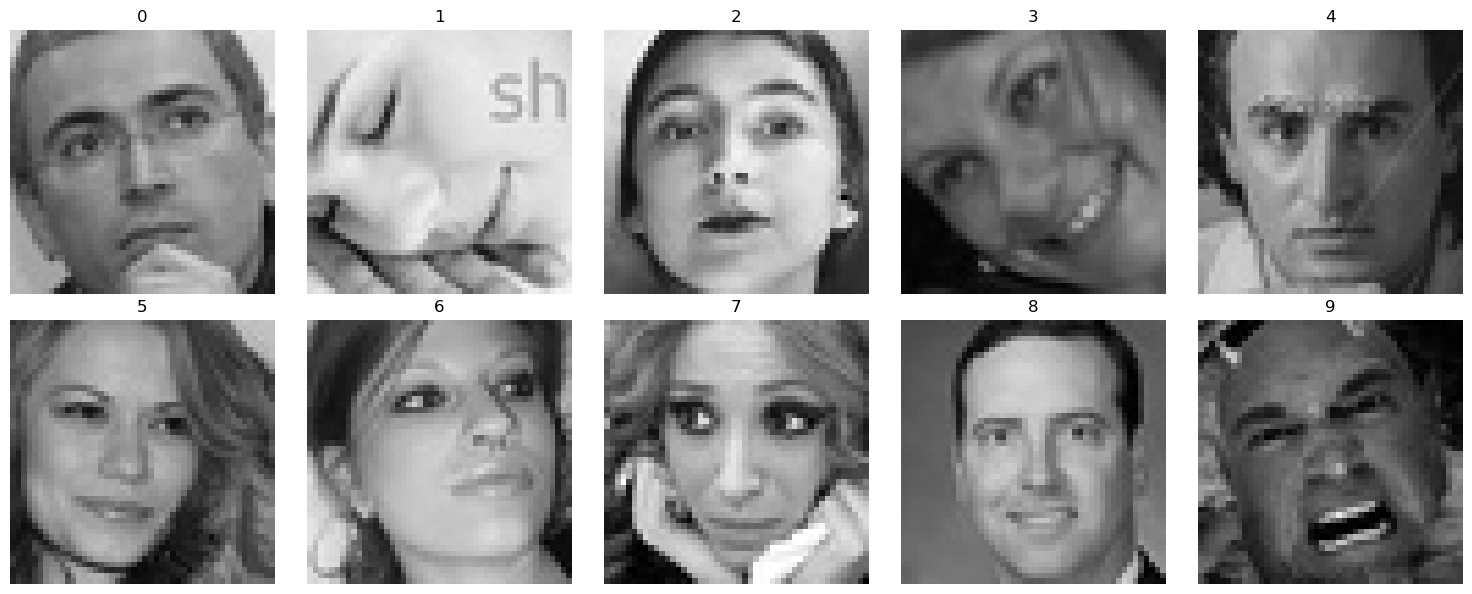

In [101]:
plt.figure(figsize=(15, 6))
for i, image in enumerate(images10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images10[i])
    plt.title(f'{i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Select Image

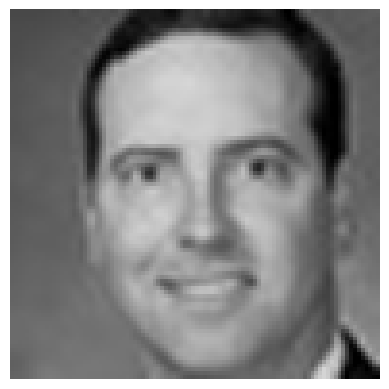

In [108]:
# Select the image number from above gallary to work with it.
SELECT_IMAGE = 8

img = images10[SELECT_IMAGE,:,:,:]

new_width = int(img.shape[1] * 2)
new_height = int(img.shape[0] * 2)
resized_image = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

plt.imshow(resized_image)
plt.axis('off')
plt.show()

## Image Color Enhancement

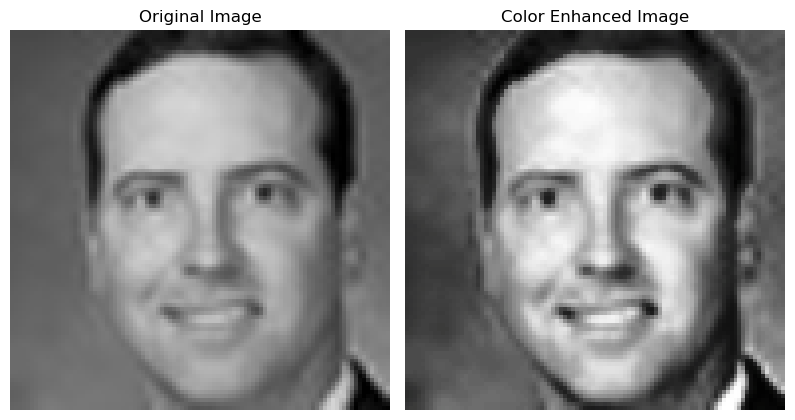

In [109]:
# CLAHE
l, a, b = cv2.split(cv2.cvtColor(resized_image, cv2.COLOR_BGR2LAB))
cl = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(2,2)).apply(l)
enhanced_color_image = cv2.cvtColor(cv2.merge((cl, a, b)), cv2.COLOR_LAB2BGR)


titles = ['Original Image', 'Color Enhanced Image']
images = [resized_image, enhanced_color_image]

plt.figure(figsize=(12, 5))
for i in range(len(titles)):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Denoising

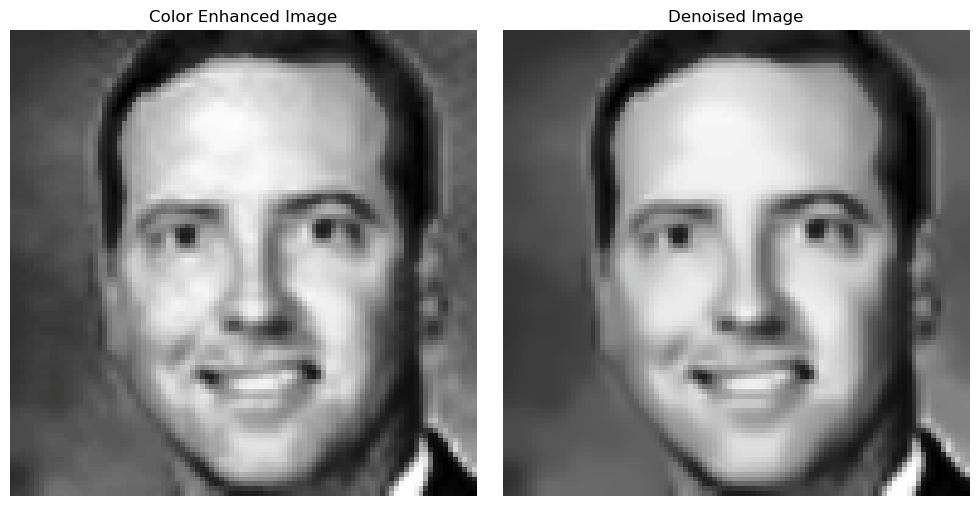

In [110]:
# guss_blur = cv2.GaussianBlur(enhanced_color_image, (3, 3), 0)
# median_blur = cv2.medianBlur(enhanced_color_image, 3)
# bilateral_blur = cv2.bilateralFilter(enhanced_color_image, d=9, sigmaColor=25, sigmaSpace=100)
# wavelet_blur = denoise_wavelet(enhanced_color_image, channel_axis=-1, rescale_sigma=True)
nonlin_blur = cv2.fastNlMeansDenoisingColored(enhanced_color_image, None, 5, 5, 5, 15)


blurred_image = nonlin_blur
titles = ['Color Enhanced Image', 'Denoised Image']
images = [enhanced_color_image, blurred_image]

plt.figure(figsize=(10, 5))
for i in range(len(titles)):
    plt.subplot(1, 2, i+1)
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Edge Detection

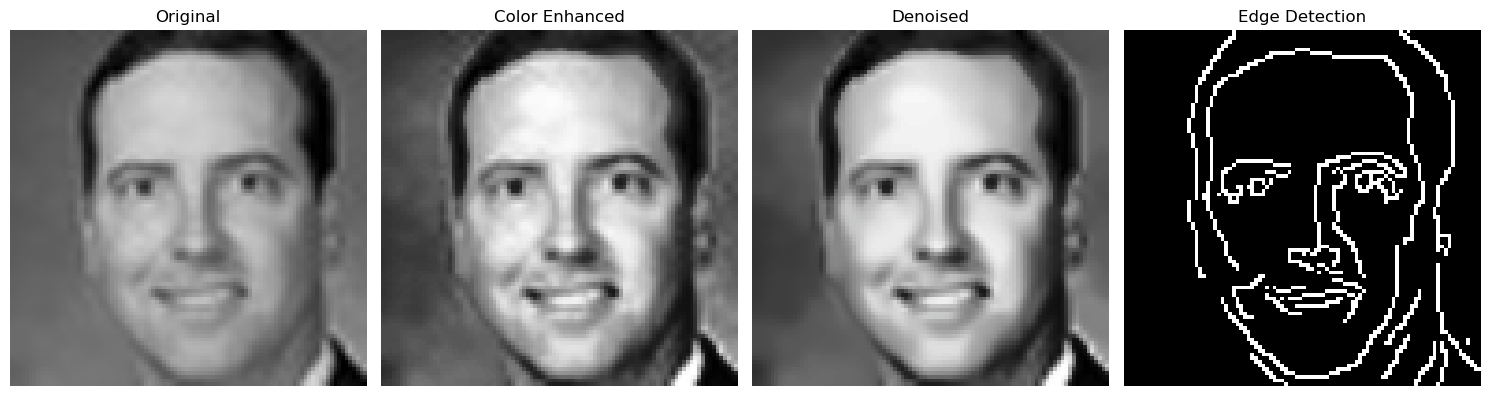

In [111]:
edges = cv2.Canny(blurred_image, 150, 255)

titles = ['Original','Color Enhanced','Denoised','Edge Detection']
images = [resized_image, enhanced_color_image, blurred_image, edges]

plt.figure(figsize=(15, 5))
for i in range(len(titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Segment facial features

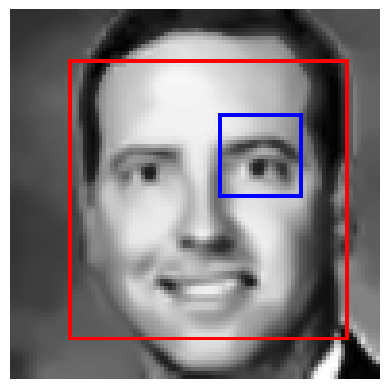

In [112]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
lefteye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_lefteye_2splits.xml')
righteye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_righteye_2splits.xml')
mouth_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_smile.xml') 
def facial_feature_detection(image):
    segment_image = image.copy()
    gray = cv2.cvtColor(segment_image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Loop over each face
    for (x, y, w, h) in faces:
        # Draw a rectangle around the face
        cv2.rectangle(segment_image, (x, y), (x+w, y+h), (255, 0, 0), 1)
        
        # Isolate the face region for more accurate eye and mouth detection
        face_region = gray[y:y+h, x:x+w]
        color_face_region = segment_image[y:y+h, x:x+w]
        
        # Detect eyes within the face region
        lefteye = lefteye_cascade.detectMultiScale(face_region, 1.1, 10)
        for (ex, ey, ew, eh) in lefteye:
            cv2.rectangle(color_face_region, (ex, ey), (ex+ew, ey+eh), (0, 0, 255), 1)

        # Detect eyes within the face region
        righteye = righteye_cascade.detectMultiScale(face_region, 1.1, 10)
        for (ex, ey, ew, eh) in righteye:
            cv2.rectangle(color_face_region, (ex, ey), (ex+ew, ey+eh), (0, 255, 0), 1)
        
        # Detect mouth (smile often overlaps mouth) within the lower part of the face
        mouths = mouth_cascade.detectMultiScale(face_region, 1.7, 20)
        for (mx, my, mw, mh) in mouths:
            if my > h / 2:  # Limit detection to lower half of the face
                cv2.rectangle(color_face_region, (mx, my), (mx+mw, my+mh), (0, 0, 255), 1)
        
        return segment_image

segment_image = facial_feature_detection(blurred_image)
if segment_image is not None:
    plt.imshow(segment_image)
    plt.axis('off')
    plt.show()
else:
    print('No features detected')

## Show 10 Images with the effect

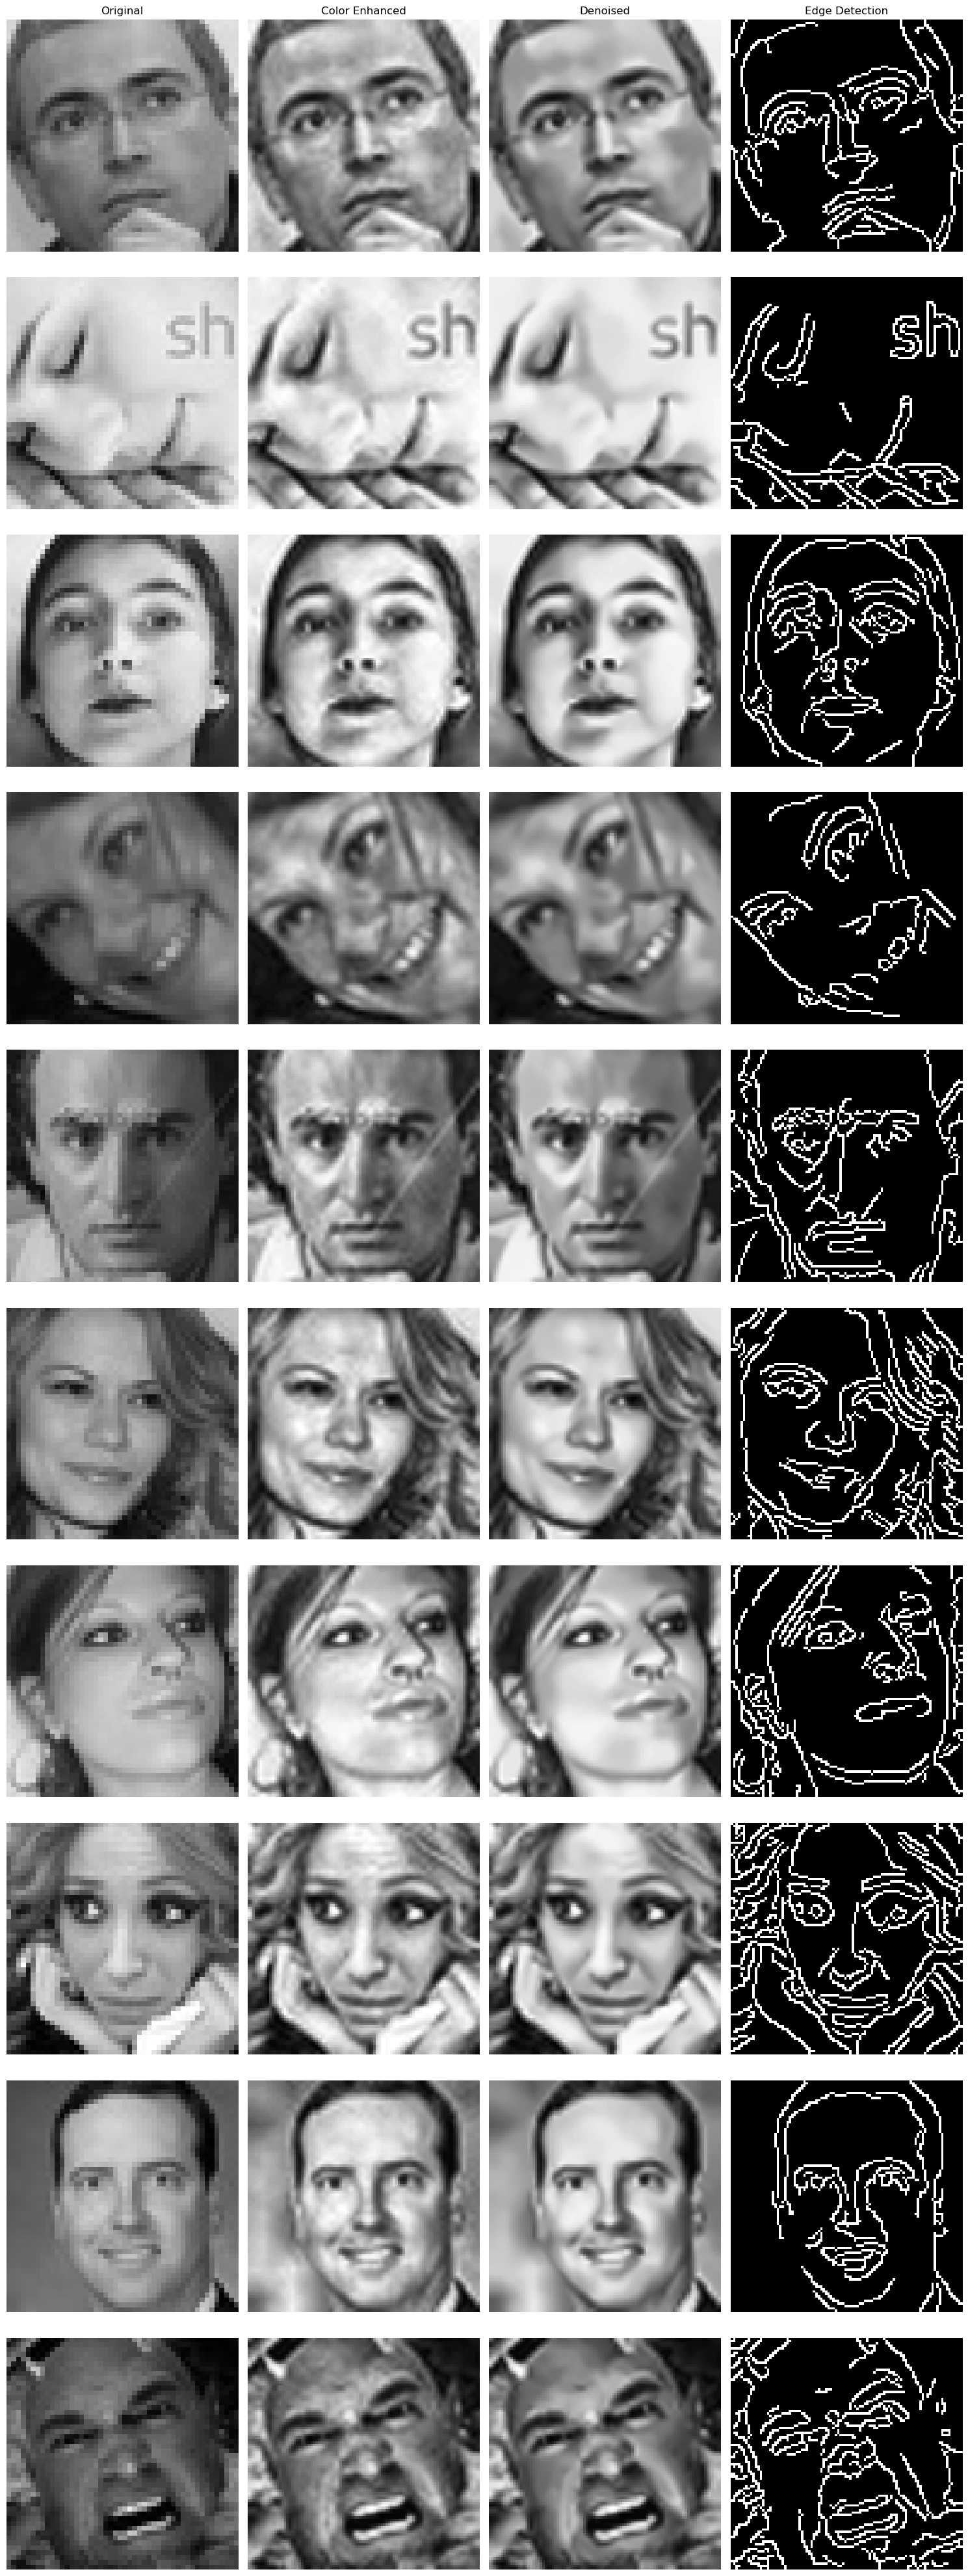

In [113]:
color_enhanced_10 = []
denoised_10 = []
edge_10 = []
for i, image in enumerate(images10):
    new_width = int(image.shape[1] * 2)
    new_height = int(image.shape[0] * 2)
    resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

    l, a, b = cv2.split(cv2.cvtColor(resized_image, cv2.COLOR_BGR2LAB))
    cl = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8)).apply(l)
    merged_lab = cv2.merge((cl, a, b))
    enhanced_color_image = cv2.cvtColor(merged_lab, cv2.COLOR_LAB2BGR)
    color_enhanced_10.append(enhanced_color_image)

    nonlin_blur = cv2.fastNlMeansDenoisingColored(enhanced_color_image, None, 5, 5, 5, 15)
    denoised_10.append(nonlin_blur)

    edges = cv2.Canny(nonlin_blur, 150, 255)
    edge_10.append(edges)





titles = ['Original', 'Color Enhanced', 'Denoised', 'Edge Detection']
plt.figure(figsize=(15, 40))  # Adjust figure size for better visibility

for row in range(10):  # Loop over each set of images in the arrays
    images = [
        cv2.cvtColor(images10[row], cv2.COLOR_BGR2RGB),
        cv2.cvtColor(color_enhanced_10[row], cv2.COLOR_BGR2RGB),
        cv2.cvtColor(denoised_10[row], cv2.COLOR_BGR2RGB),
        cv2.cvtColor(edge_10[row], cv2.COLOR_BGR2RGB)
    ]
    
    for col in range(4):  # Loop over each column per row
        plt.subplot(10, 4, row * 4 + col + 1)
        plt.imshow(images[col])
        if row == 0:  # Only add titles on the first row
            plt.title(titles[col])
        plt.axis('off')

plt.tight_layout()
plt.show()
